# Histopathologic Cancer Detection
Week 3 Mini‑Project – EDA → Baseline Training → Kaggle Submission

In [81]:
from pathlib import Path
import warnings, random, os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from PIL import Image
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [82]:
# --- Load CSV and keep only rows whose images exist ---
DATA_DIR  = Path('histopathologic-cancer-detection')
TRAIN_DIR = DATA_DIR/'train'
TEST_DIR  = DATA_DIR/'test'

df = pd.read_csv(DATA_DIR/'train_labels.csv')
existing = {p.stem for p in TRAIN_DIR.glob('*.tif')}
df = df[df['id'].isin(existing)].reset_index(drop=True)
print('Images after filtering:', len(df))
df.head()

Images after filtering: 21294


,id,label
0,068aba587a4950175d04c680d38943fd488d6a9d,0
1,08566ce82d4406f464c9c2a3cd014704735db7a9,0
2,0b820b71670c039dd0a51333d1c919f471a9e940,1
3,10252ba9b4461d62e79549a95f045bec00f405d1,0
4,103cce98466382a6c8d5b07d5d0ddc8d3b073bfd,0


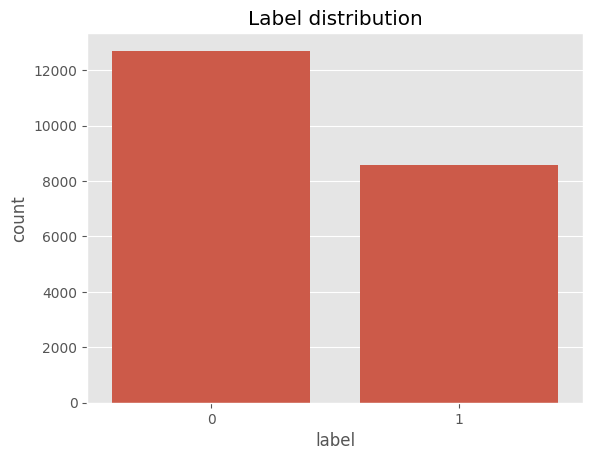

In [83]:
sns.countplot(x='label', data=df)
plt.title('Label distribution'); plt.show()

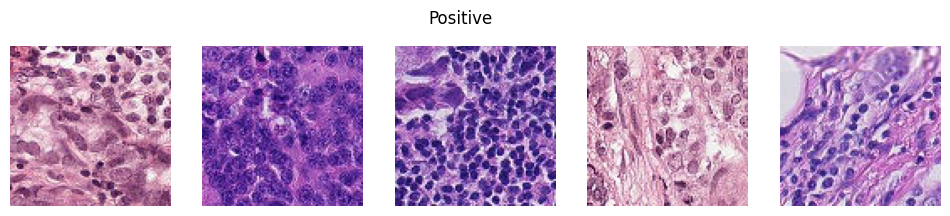

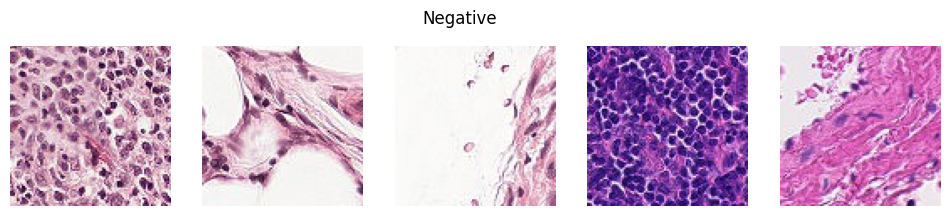

In [84]:
# --- Show sample images ---
def show_samples(ids, title):
    fig, axes = plt.subplots(1, len(ids), figsize=(len(ids)*2.4, 2.4))
    for ax, img_id in zip(axes, ids):
        ax.imshow(Image.open(TRAIN_DIR/f"{img_id}.tif")); ax.axis('off')
    fig.suptitle(title); plt.show()

show_samples(df[df.label==1]['id'].sample(5, random_state=0), 'Positive')
show_samples(df[df.label==0]['id'].sample(5, random_state=0), 'Negative')

## PyTorch Dataset / DataLoader

In [85]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class HistDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir; self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_id = self.df.loc[idx, 'id']
        label  = self.df.loc[idx, 'label']
        img    = Image.open(self.img_dir / f"{img_id}.tif")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)

In [86]:
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])
val_tfms = transforms.ToTensor()

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_loader = DataLoader(HistDataset(train_df, TRAIN_DIR, train_tfms), batch_size=64, shuffle=True,  num_workers=0)
val_loader   = DataLoader(HistDataset(val_df,   TRAIN_DIR, val_tfms),   batch_size=64, shuffle=False, num_workers=0)
len(train_loader), len(val_loader)

(267, 67)

## Simple CNN model

In [87]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(128, 1)
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x).squeeze(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = SimpleCNN().to(device)

## Training loop (example: 3 epochs)

In [88]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion  = nn.BCEWithLogitsLoss()

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    tot, n = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train:
            optimizer.zero_grad()
        logits = model(x)
        loss   = criterion(logits, y)
        if train:
            loss.backward(); optimizer.step()
        tot += loss.item() * len(x); n += len(x)
    return tot / n

for ep in range(3):
    tl = run_epoch(train_loader, True)
    vl = run_epoch(val_loader, False)
    print(f"Epoch {ep+1}: train {tl:.4f} | val {vl:.4f}")

Epoch 1: train 0.5421 | val 0.5083
Epoch 2: train 0.4703 | val 0.4687
Epoch 3: train 0.4528 | val 0.4282


## Inference & submission.csv generation

In [89]:
class TestDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.paths = sorted(img_dir.glob('*.tif'))
        self.tf    = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]; img = Image.open(p)
        return self.tf(img), p.stem

test_loader = DataLoader(TestDataset(TEST_DIR, transforms.ToTensor()), batch_size=128, shuffle=False, num_workers=0)

model.eval(); ids, preds = [], []
with torch.no_grad():
    for x, stems in test_loader:
        prob = torch.sigmoid(model(x.to(device))).cpu().numpy()
        preds.extend(prob); ids.extend(stems)

sub = pd.DataFrame({'id': ids, 'label': preds})
sub.to_csv('submission.csv', index=False)
sub.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.462653
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.470682
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.229931
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.581095
4,000270442cc15af719583a8172c87cd2bd9c7746,0.022224
